In [1]:
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import time
import scipy.stats as sc
from scipy.stats import laplace
from sklearn.linear_model import LinearRegression

# Задание 1. 


Смоделируем измерения Yk c ошибками, имеющими распределение Лапласа


Начальные условия:

In [28]:
n = 30 # количество измерений, 30-40
h = 6 # шаг измерений, 3-6 с
v = 0.2 # скорость, 0.2-0.3 км/с
sko = 1 # СКО, 1-2 км
m = 0 # математическое ожидание
alpha = 0.05 # уровень значимости доверительного интервала
probability = 1 - alpha # вероятность попадания величины в промежуток (-u_a; u_a)
ur_znach = 1.96 # значение по таблице 
# Ф(x) = (1 - alpha) / 2 = 0.95 / 2 = 0.475

Создадим список с тактами, в которые происходят измерения:

In [29]:
t = np.array([(h * i) for i in range(n)]) #такты, в которые происходят измерения

In [30]:
print(t)

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174]


Зададим начальные координаты. При этом должно выполняться условие 100 < (x*x + y*y)^0.5 < 150

In [31]:
x_0 = 0
y_0 = 150

Вычислим координаты в каждый момент времени:

In [32]:
x_izm = np.array([x_0 + v * i * np.cos(30) for i in t ])
y_izm = np.array([y_0 + v * i * np.sin(30) for i in t ])

In [33]:
# plt.figure(figsize=(18, 10))
# plt.plot(x_izm, y_izm, label = 'Траектория полета ЛА')
# plt.ylabel('Y')
# plt.xlabel('X')
# plt.legend(bbox_to_anchor=(0.8, 0.8), loc='upper left', borderaxespad=0.)
# plt.show()

Сформируем набор истинных измерений (без учета ошибок), как быдто мы знаем точную дальность r ЛА в каждый такт

In [34]:
r_real = (np.array(x_izm)**2 + np.array(y_izm)**2)**0.5

In [35]:
r_real

array([150.        , 148.81447717, 147.62918827, 146.44413899,
       145.2593352 , 144.07478293, 142.89048846, 141.70645824,
       140.52269896, 139.33921752, 138.15602105, 136.97311696,
       135.79051286, 134.60821669, 133.4262366 , 132.2445811 ,
       131.06325894, 129.88227924, 128.70165141, 127.52138523,
       126.34149084, 125.16197874, 123.98285985, 122.8041455 ,
       121.62584745, 120.44797791, 119.27054959, 118.09357567,
       116.91706988, 115.7410465 ])

### Пункт 1. Ошибки с нормальным распределением

График плотности нормального распределения (просто нарисовали для пониамния, с чем работаем)

In [36]:
def gaussian(x, mu, sigma):
     return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (x - mu)**2 / sigma**0.5)

In [37]:
disrt_x = np.arange(-3, 3, 0.05)

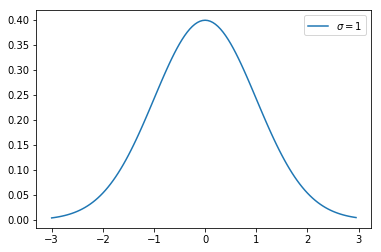

In [38]:
plt.plot(disrt_x, [gaussian(i, m, sko) for i in disrt_x], label='$\sigma = 1$')
plt.legend()
plt.show()

Добавим на измерения ошибки, распределенные нормально

С помощью встроенной функции на питон, выдающей случаные величины по заданному распределению, получим вектор ошибок, распределенных нормало

In [39]:
Wk = np.array([np.random.normal(-1, 1) for i in range(n)]) # дисперсия 1 км

In [40]:
Wk

array([ 0.57354114, -1.78397407, -1.20308596, -1.11268098, -2.0662332 ,
       -0.22486884, -1.49939334, -2.15456676, -0.50557923, -1.92250923,
       -0.98332428, -2.00761973, -2.77420524, -2.85725164, -1.42215494,
        0.84086673,  0.84667906, -0.62080968, -1.88124653, -0.58702657,
       -1.52398775, -0.16674742, -0.34803259,  0.52018176, -0.38132003,
        0.06368932, -1.20080834, -0.11156761,  0.09934664, -0.96494693])

In [9]:
np.random.laplace(0,1)

-0.23656118720227826

Напишем функцию плостности нормального распределения (проверить!)

In [41]:
# def f_norm(x):
#     return 1 / (sko * (2 * np.pi)**0.5) * np.exp((x - m)**2/(2 * sko**2))

In [42]:
Yk_1 = r_real + np.array(Wk)

In [43]:
Yk_1

array([150.57354114, 147.0305031 , 146.42610231, 145.33145802,
       143.19310199, 143.84991409, 141.39109512, 139.55189148,
       140.01711973, 137.41670829, 137.17269677, 134.96549722,
       133.01630763, 131.75096505, 132.00408167, 133.08544782,
       131.909938  , 129.26146956, 126.82040488, 126.93435866,
       124.81750309, 124.99523132, 123.63482726, 123.32432726,
       121.24452742, 120.51166723, 118.06974124, 117.98200806,
       117.01641652, 114.77609957])

### Пункт 2. Ошибки с распределением Лапласа

Плотность распределения Лапласса

In [44]:
def lapl(x): 
    return 1/(sko * 2**0.5) * np.exp(-abs(x) * 2**0.5 / sko)

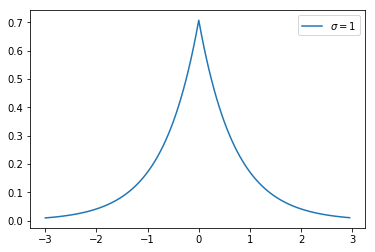

In [45]:
plt.plot(disrt_x, [lapl(i) for i in disrt_x], label='$\sigma = 1$')
plt.legend()
plt.show()

In [46]:
#sc.norm.cdf(np.linspace(0,1,101)) - 0.5

# Задание 2.

Решение аналитически, матричным способом

In [47]:
A = sum(Yk_1)
B = sum(t * Yk_1)
ResC = np.array([A, B])

In [48]:
c11 = n
c12 = sum(np.array(t))
c21 = sum(np.array(t))
c22 = sum(np.array(t)**2)
C = np.array([[c11, c12], [c21, c22]])

In [49]:
C1 = np.array([[A, c12], \
               [B, c22]])
C2 = np.array([[c11, A],\
               [c21, B]])

In [50]:
C1det = np.linalg.det(C1)
C2det = np.linalg.det(C2)
Cdet = np.linalg.det(C)

In [51]:
thet1 = C1det / Cdet
thet2 = C2det / Cdet
print(thet1, thet2)
r = thet1 + thet2 * np.array(t)

148.51190874766837 -0.19052962105323143


Функция "из коробки"

In [52]:
theta_1, theta_2 = np.linalg.solve(C, ResC)
print(theta_1, theta_2)
r1 = theta_1 + theta_2 * np.array(t)

148.51190874766837 -0.19052962105323132


Подсчет с помощью функции:

In [53]:
from numpy.linalg import inv
def mls(k, x, y):
    x = np.array(x)
    t = np.array([[i**j for i in x] for j in reversed(range(k))])
    t_trans = np.transpose(t)
    g = t @ t_trans
    a = inv(g) @ t @ y
    return a

In [54]:
theta_01, theta_02 = mls(2, t, Yk_1)
print(theta_01, theta_02)
r0 = theta_02 + theta_01 * np.array(t)

-0.1905296210532299 148.51190874766814


Построение доверительного интервала

Посчитаем границы промежутка (-u_a; u_a):

Дисперсия МНК-оценки, выборочная дисперсия

In [34]:
# u = (ur_znach * sko / (n)**2)
# print(u)

In [55]:
S = 1 / n * sum((r - np.mean(r))**2)

Доверительный интервал:

In [57]:
r_uleft = r - ur_znach * S**0.5
r_urght = r + ur_znach * S**0.5

Графики истинной, измеренной, оцененной дальности, доверительного интервала

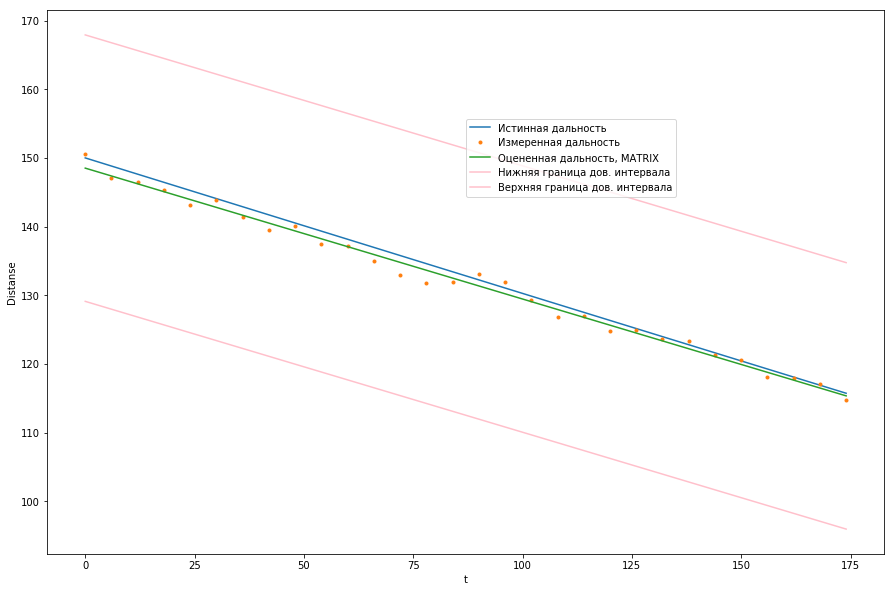

In [58]:
plt.figure(figsize=(15, 10))
plt.plot(t, r_real, label = 'Истинная дальность')
plt.plot(t, Yk_1, '.', label = 'Измеренная дальность')
# plt.plot(t, r0, label = 'Оцененная дальность, Dima')
plt.plot(t, r, label = 'Оцененная дальность, MATRIX')
plt.plot(t, r_uleft, 'pink', label = 'Нижняя граница дов. интервала')
plt.plot(t, r_urght, 'pink', label = 'Верхняя граница дов. интервала')
plt.ylabel('Distanse')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

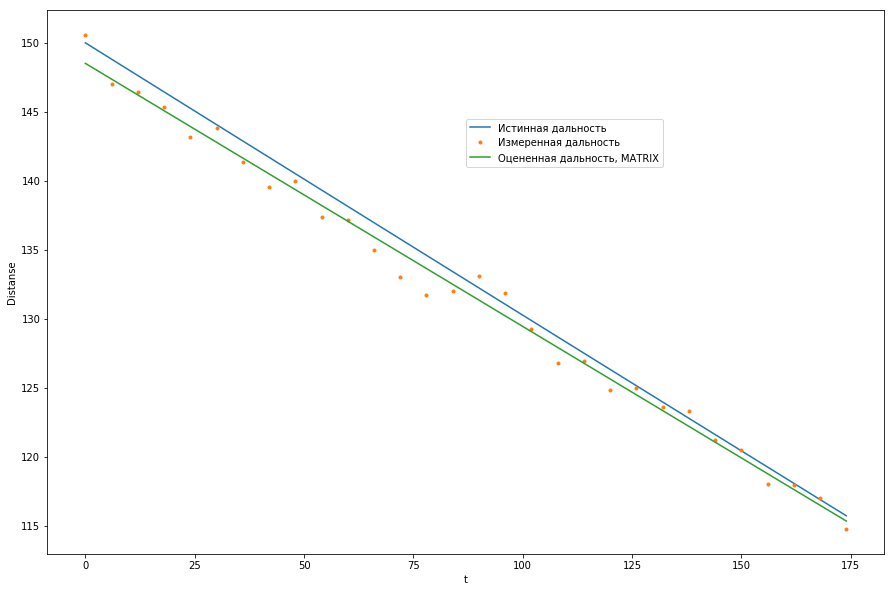

In [59]:
plt.figure(figsize=(15, 10))
plt.plot(t, r_real, label = 'Истинная дальность')
plt.plot(t, Yk_1, '.', label = 'Измеренная дальность')
# plt.plot(t, r0, label = 'Оцененная дальность, Dima')
plt.plot(t, r, label = 'Оцененная дальность, MATRIX')
plt.ylabel('Distanse')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

# Задание 3.

Решим задачу поиска параметров матричным способом

In [60]:
d11 = n
d12 = sum(t)
d13 =sum(t**2)
d21 = sum(t)
d22 = sum(t**2)
d23 = sum(t**3)
d31 = sum(t**2)
d32 = sum(t**3)
d33 = sum (t**4)
D = np.array([[d11, d12, d13], \
             [d21, d22, d23], \
             [d31, d32, d33]])
print(D)

[[        30       2610     307980]
 [      2610     307980   40872600]
 [    307980   40872600 5785342704]]


In [61]:
A_1 = sum(Yk_1)
A_2 = sum(Yk_1 * t)
A_3 = sum(Yk_1 * t**2)
A_ = np.array([A_1, A_2, A_3])
print(A_)

[3.95807495e+03 3.28936769e+05 3.79673278e+07]


In [62]:
teta_1, teta_2, teta_3 = np.linalg.solve(D, A_)
print(teta_1, teta_2, teta_3)
r_ = teta_1 + teta_2 * t + teta_3 * t**2 / 2

148.96192980948055 -0.20660180183223742 9.236885505175788e-05


Аналогично заданию 2 построим графические данные для задания 3

Границы промежутка:

Дисперсия МНК-оценки, выборочная дисперсия

In [63]:
S = 1 / n * sum((r_ - np.mean(r_))**2)

Графики истинной, измеренной, оцененной дальности, доверительного интервала

In [64]:
r_uleft_3 = r_ - ur_znach * S**0.5
r_urght_3 = r_ + ur_znach * S**0.5

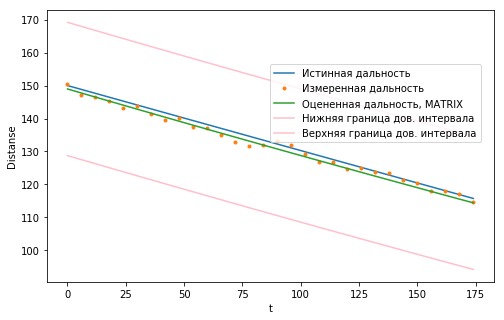

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(t, r_real, label = 'Истинная дальность')
plt.plot(t, Yk_1, '.', label = 'Измеренная дальность')
# plt.plot(t, r0, label = 'Оцененная дальность, Dima')
plt.plot(t, r_, label = 'Оцененная дальность, MATRIX')
plt.plot(t, r_uleft_3, 'pink', label = 'Нижняя граница дов. интервала')
plt.plot(t, r_urght_3, 'pink', label = 'Верхняя граница дов. интервала')
plt.ylabel('Distanse')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(0.5, 0.8), loc='upper left', borderaxespad=0.)

plt.show()

# Задание 4

На уровне значимости $\alpha$ проверить гипотезу $H_{0} : \{\theta_{3}=0\}$


Найдем t-критическое по таблице распределения Стьюдента на уровне значимости $\alpha = 0,05$. 
$t_{n-k}$, где $n$ - число измерений (величина выборки), $k$ - число оцениваемых параметров
$t_{30-3}=t_{27}=2,0518$ 

In [181]:
t_cr = 2.0518

Дисперсия оцененной дальности

In [180]:
varRes = sum([(xi - np.mean(r_))**2 for xi in r_]) / (len(r_) -1)
print(varRes)

103.99954536103446


Вычисление матрицы ковариации для оценки параметров

Матрица T - это матрица X из формулы в видео мужика про составление матрицы ковариации (см крайнее фото в телеграме черной ручкой, сама формула в вк на листочке черной ручкой, видео в вк ссылка)

In [149]:
T = np.matrix([np.ones(n), t, t**2/2])

Транспонируем, чтобы она приняла правильный вид для дальнейших действий (а то она сейчас записана в виде строк питоном)

In [151]:
T = T.transpose()

In [183]:
COV = varRes * inv(T.transpose().dot(T))

In [184]:
COV

matrix([[ 2.73837513e+01, -6.18545683e-01,  5.82434730e-03],
        [-6.18545683e-01,  1.93824523e-02, -2.08012404e-04],
        [ 5.82434730e-03, -2.08012404e-04,  2.39094717e-06]])

Для расчета доверительного интервала необходим параметр на диагонали - стандартная ошибка: $se_{teta}$

для того, чтобы запомнить или провести ананлогию, будем считать, что se_teta - аналог среднеквадратического отклонения (НЕ ГОВОРИТЬ ЭТО ПРЕПУ! УБЬЕТ!)

НАХОДИТСЯ ПО ФОРМУЛЕ ИЗ ВИДЕО МУЖИКА

In [188]:
se_teta = COV[2, 2]**0.5

Доверительный интервал для параметра $\theta_{3}=0$ расчитывается по формуле:

In [195]:
print('Доверительный интервал для teta_3:')
print('[', teta_3 - t_cr * se_teta, ',', teta_3 + t_cr * se_teta, ']')

Доверительный интервал для teta_3:
[ -0.003126195535784051 , 0.0032190730654477664 ]


Так как 0 попадает в доверительный интервал, построенный для $\theta_{3}=0$, гипотеза $H_{0} : \{\theta_{3}=0\}$ не отклоняется.

Для аппроксимации достаточно выбрать модель простой линейной регрессии,  так как гипмотеза о тета=0 подтвердилась, значит, третий оцененный параметр не влияет на уравнение дальности (так как ЛА по условию задачи движется равномерно и прямолинейно )

# Задание 5

Выбрана модель простой линейной регрессии. Построим для нее гистограмму вектора остатков

Остатки:

In [68]:
residual = r_ - Yk_1
# r_ - оцененная дальность с помощью МНК (зеленая прямая)
#Yk_1 - измеренная дальность (оранжевые точки)
# print(residual)

Text(0.5,1,'Распределение остатков')

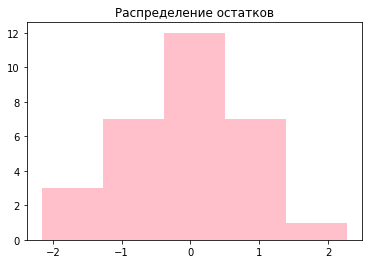

In [48]:
# скопировала в rr наши остатки, чтобы их не изменить случайно
rr = deepcopy(residual) 
# сортирую по возрастанию
rr = sorted(rr)

#
left = min(rr)-0.5
right = max(rr)+0.5
bins_s = [i for i in np.linspace(left, right, 6)]

hh = (right - left) / 6
# distr_array = []
# for j in range(len(bins_s)-1):
#     tmp = []
#     for i in range(len(rr)):
#         if (rr[i] > bins_s[j] and rr[i] < bins_s[j+1]):
#             tmp += [rr[i]]
#     distr_array .append(np.array(tmp))
    
# distr_array = np.array(distr_array)     
# heights = [len(i) for i in distr_array]

_, ax = plt.subplots()
ax.hist(residual, bins = bins_s, color = 'pink')
ax.set_title('Распределение остатков')

/Users/synthtron/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


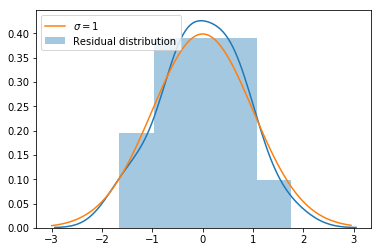

In [49]:
sns_plot = sns.distplot(residual, label = 'Residual distribution')
fig = sns_plot.get_figure()

xs = np.arange(-3, 3, 0.05) # Сетка значений по оси абсцисс.
p2, = plt.plot(xs, [gaussian(x, 0, 1) for x in xs], label='$\sigma = 1$')
plt.legend()
plt.show()

# Задание 6

На уровне значимости $\alpha = 0.05$ по критерию хи-квадрат проверить гипотезу о том, что ошибки подчиняются нормальному распределению $N(0,\sigma)$

Если $\chi^{2}_{1} <= \chi^{2} <= \chi^{2}_{2}$, то гипотеза выполняется

In [50]:
# hi_square = sum(()/)
# print(hi_square)

Определим по таблице распределения хи-квадрат

In [51]:
# hi_right = 17,7084

In [52]:
# hi_left = 

In [53]:
85.2*4.7/(200*2)

1.0011

In [54]:
200*2/4.7 * 0.1957

16.655319148936172

In [55]:
bins_s

[-2.1539493562809184,
 -1.2699376505941102,
 -0.38592594490730225,
 0.4980857607795057,
 1.382097466466314,
 2.266109172153122]

In [56]:
rr = deepcopy(residual)
rr = sorted(rr)
print(rr)
left = -2
right = 2
bins = [i for i in np.linspace(left, right, 6)]
print(bins)
distr_array = []
for j in range(len(bins)-1):
    tmp = []
    for i in range(len(rr)):
        if (rr[i] > bins[j] and rr[i] < bins[j+1]):
            tmp += [rr[i]]
    distr_array .append(np.array(tmp))
    
distr_array = np.array(distr_array)     
heights = [len(i) for i in distr_array]
print(heights)


[-1.6539493562809184, -1.416685753176722, -1.4095073132988034, -1.0322258295451832, -0.6993725995235707, -0.5978048191953462, -0.5155818856168821, -0.5097840357656054, -0.40432211539481955, -0.39697175576922916, -0.36288304366246393, -0.34750391853197016, -0.2282613568478098, -0.22455162706074816, -0.011254220788998737, 0.07096811420909432, 0.16661548630736434, 0.20878957945447496, 0.37504543870744556, 0.386948362498174, 0.4146467173005277, 0.42785048658687685, 0.6474786222437103, 0.6636998665148894, 0.7362733954992677, 0.8317110719153504, 0.8805572119111389, 0.9380089701181191, 1.295957135039032, 1.7661091721531221]
[-2.0, -1.2, -0.3999999999999999, 0.40000000000000036, 1.2000000000000002, 2.0]
[3, 6, 11, 8, 2]


In [60]:
np.mean(np.array(rr))

-1.6105635343895604e-14

In [61]:
for i in distr_array:
    sr_vzvesh = sum(i * len(i))/len(i)
print(sr_vzvesh)

# sko_vzvesh = 

3.062066307192154
